In [1]:
from tsai.models import InceptionTime, TST, ResNet
# from tsai.data.core import get_UCR_data
# from tsai.learner import TSClassifier
import os
import numpy as np
import sys
print(sys.executable)
import sys
sys.path.insert(1, '../src/')
from CNN_classifier_model import CNNClassifier, train_model, evaluate_model
from config import raw_data_path, univariate_data_path, processed_data_path
from preprocessing_modules import create_time_windows_with_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import wandb
wandb.login(key="5f15eb7efc1e0e939ccc83345338a0b8c24e2fbc")


/home/nwertheim/miniconda3/bin/python


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/nwertheim/.netrc
wandb: Currently logged in as: noorwertheim to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
import wandb
from fastai.callback.wandb import WandbCallback

# Initialize WandB logging
wandb.init(project='ResNet')

744
192
{'record_name': 'Hopper-2024_09_17_06_51_03-0000010009-0001-chan0', 'signal': array([[ -5.57103828],
       [-11.39992724],
       [ -9.53483775],
       ...,
       [  0.73235611],
       [ -0.1656677 ],
       [  1.35035514]]), 'fs': 20, 'preterm': 0}
Train label distribution:
  Term (0): 3360
  Preterm (1): 5748

Test label distribution:
  Term (0): 390
  Preterm (1): 2322
torch.Size([9108])
9108


epoch,train_loss,valid_loss,accuracy,time
0,0.664187,0.593519,0.856195,00:15
1,0.658283,0.544578,0.856195,00:15
2,0.658218,0.542147,0.856195,00:15
3,0.657956,0.541301,0.856195,00:15
4,0.656812,0.530518,0.856195,00:15
5,0.655268,0.534090,0.856195,00:15


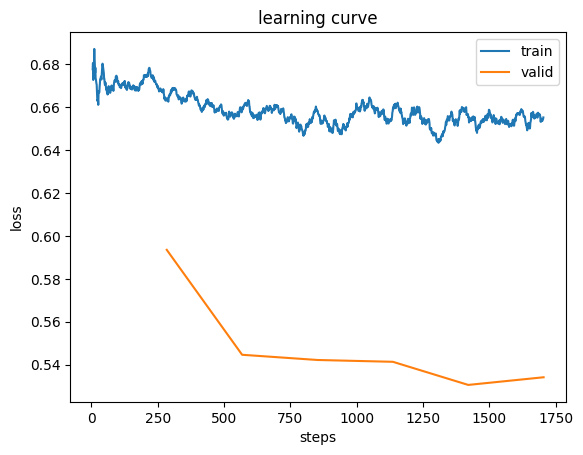

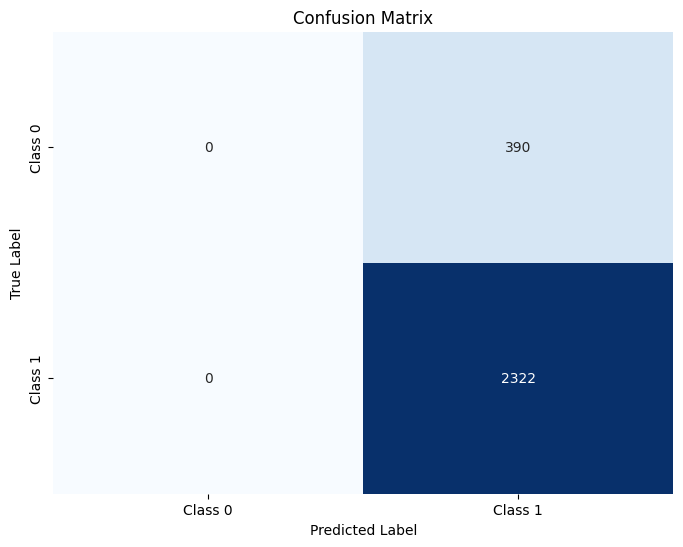

Accuracy: 0.8562
Precision: 0.8562
Recall: 1.0000
F1 Score: 0.9225
Average Precision (AP): 0.8297
Area Under ROC Curve (AUC): 0.4887


In [3]:

'''MY DATA'''
train_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_old_train_old.npy")
train_data = np.load(train_dir, allow_pickle=True)
# train_data = pd.DataFrame(train_data)
test_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_old_test_old.npy")
test_data = np.load(test_dir, allow_pickle=True)
# test_data = pd.DataFrame(test_data)
print(len(train_data))
print(len(test_data))
print(train_data[0])
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter

# Example dataset with windows and labels
train_windows, train_labels = create_time_windows_with_labels(train_data)
test_windows, test_labels = create_time_windows_with_labels(test_data)

# Count label distribution
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

# Print the counts
print("Train label distribution:")
print(f"  Term (0): {train_label_counts[0]}")
print(f"  Preterm (1): {train_label_counts[1]}")

print("\nTest label distribution:")
print(f"  Term (0): {test_label_counts[0]}")
print(f"  Preterm (1): {test_label_counts[1]}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Convert to tensors
train_windows_tensor = torch.tensor(train_windows, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_windows_tensor = torch.tensor(test_windows, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

train_windows_tensor = train_windows_tensor.unsqueeze(1)  # (1071, 1, 12000)
test_windows_tensor = test_windows_tensor.unsqueeze(1)    # (899, 1, 12000)

train_labels_tensor = train_labels_tensor.long()
test_labels_tensor = test_labels_tensor.long()


print(train_labels_tensor.shape)

train_dataset = TensorDataset(train_windows_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_windows_tensor, test_labels_tensor)

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_windows_tensor))


'''CROSSENTROPY LOSS'''
from tsai.models import ResNet
from tsai.models.ResNet import ResNet
from fastai.metrics import accuracy
from fastai.data.core import DataLoaders
from fastai.learner import Learner
import torch
from fastai.losses import CrossEntropyLossFlat
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wrap your DataLoaders and set device
dls = DataLoaders.from_dsets(
    train_dataset,
    test_dataset,
    bs=32,
    shuffle=True,
    num_workers=0  # avoid multiprocessing issues
)
# Define model
model = ResNet(1, 2)

# Create Learner
# learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
# learn = Learner(dls, model, loss_func=torch.nn.CrossEntropyLoss(), metrics=accuracy, cbs=[WandbCallback()])
learn = Learner(dls, model, loss_func=torch.nn.CrossEntropyLoss(), metrics=accuracy)

# Optionally convert model to FP32 (if it was FP16 before), and ensure model is on correct device
learn.model.to(device)

learn.dls.to(device)
# Train
learn.fit_one_cycle(6, 1e-6)


learn.recorder.plot_loss()  # Plot loss curves (training and validation loss)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

# Get predictions and true labels
preds, targs = learn.get_preds(dl=learn.dls.valid)

# Convert predictions to class labels (argmax for multi-class classification)
pred_labels = preds.argmax(dim=1)

# Compute confusion matrix
cm = confusion_matrix(targs, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    roc_auc_score
)

# Convert to numpy arrays if needed
true_labels = targs.cpu().numpy()
pred_labels = pred_labels.cpu().numpy()
pred_probs = preds[:, 1].cpu().numpy()  # Probability of class 1

# Compute metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, zero_division=0)
recall = recall_score(true_labels, pred_labels, zero_division=0)
f1 = f1_score(true_labels, pred_labels, zero_division=0)
ap = average_precision_score(true_labels, pred_probs)
auc = roc_auc_score(true_labels, pred_probs)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Average Precision (AP): {ap:.4f}")
print(f"Area Under ROC Curve (AUC): {auc:.4f}")


744
192
{'record_name': 'Hopper-2024_09_17_06_51_03-0000010009-0001-chan0', 'signal': array([[ -5.57103828],
       [-11.39992725],
       [ -9.53483776],
       ...,
       [  0.73235611],
       [ -0.1656677 ],
       [  1.35035514]]), 'fs': 20, 'preterm': 0}
Train label distribution:
  Term (0): 3360
  Preterm (1): 5748

Test label distribution:
  Term (0): 390
  Preterm (1): 2322
torch.Size([9108])


epoch,train_loss,valid_loss,accuracy,time
0,0.690399,0.664581,0.712021,00:15
1,0.689830,0.680933,0.672198,00:15
2,0.686582,0.673948,0.695059,00:15
3,0.684741,0.683565,0.672935,00:15
4,0.684716,0.668542,0.687316,00:15


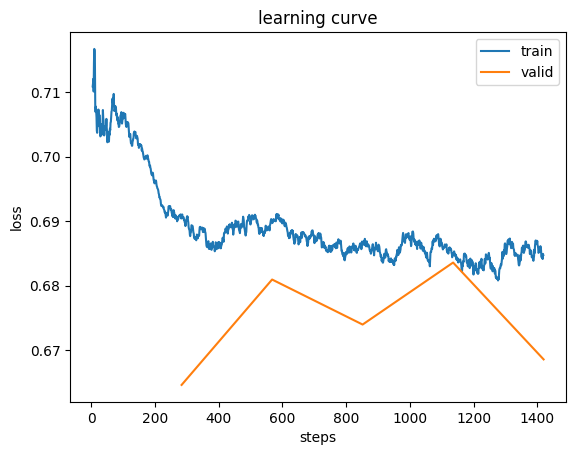

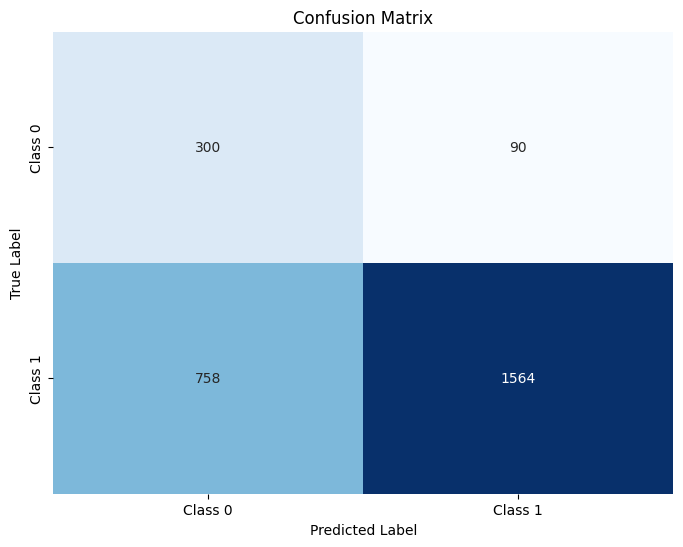

Accuracy: 0.6873
Precision: 0.9456
Recall: 0.6736
F1 Score: 0.7867
Average Precision (AP): 0.9580
Area Under ROC Curve (AUC): 0.7676


In [13]:

'''MY DATA + class weights'''
train_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_train.npy")
train_data = np.load(train_dir, allow_pickle=True)
# train_data = pd.DataFrame(train_data)
test_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_test.npy")
test_data = np.load(test_dir, allow_pickle=True)
# test_data = pd.DataFrame(test_data)
print(len(train_data))
print(len(test_data))
print(train_data[0])
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.utils.class_weight import compute_class_weight
from fastai.losses import CrossEntropyLossFlat

from collections import Counter

# Example dataset with windows and labels
train_windows, train_labels = create_time_windows_with_labels(train_data)
test_windows, test_labels = create_time_windows_with_labels(test_data)

# Count label distribution
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

# Print the counts
print("Train label distribution:")
print(f"  Term (0): {train_label_counts[0]}")
print(f"  Preterm (1): {train_label_counts[1]}")

print("\nTest label distribution:")
print(f"  Term (0): {test_label_counts[0]}")
print(f"  Preterm (1): {test_label_counts[1]}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Convert to tensors
train_windows_tensor = torch.tensor(train_windows, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_windows_tensor = torch.tensor(test_windows, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

train_windows_tensor = train_windows_tensor.unsqueeze(1)  # (1071, 1, 12000)
test_windows_tensor = test_windows_tensor.unsqueeze(1)    # (899, 1, 12000)

train_labels_tensor = train_labels_tensor.long()
test_labels_tensor = test_labels_tensor.long()


print(train_labels_tensor.shape)

train_dataset = TensorDataset(train_windows_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_windows_tensor, test_labels_tensor)

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



'''CROSSENTROPY LOSS + CLASS WEIGHTS'''
from tsai.models import ResNet
from tsai.models.ResNet import ResNet
from fastai.metrics import accuracy
from fastai.data.core import DataLoaders
from fastai.learner import Learner
import torch

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wrap your DataLoaders and set device
dls = DataLoaders.from_dsets(
    train_dataset,
    test_dataset,
    bs=32,
    shuffle=True,
    num_workers=0  # avoid multiprocessing issues
)
# Define model
model = ResNet(1, 2)

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Use weighted loss
# loss_func = CrossEntropyLossFlat(weight=class_weights_tensor) # CrossEntropyLossFlat
loss_func=torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
# Replace your loss function in the learner
learn = Learner(dls, model, loss_func=loss_func, metrics=accuracy)


# Optionally convert model to FP32 (if it was FP16 before), and ensure model is on correct device
learn.model.to(device)

learn.dls.to(device)
# Train
learn.fit_one_cycle(5, 1e-5)


learn.recorder.plot_loss()  # Plot loss curves (training and validation loss)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

# Get predictions and true labels
preds, targs = learn.get_preds(dl=learn.dls.valid)

# Convert predictions to class labels (argmax for multi-class classification)
pred_labels = preds.argmax(dim=1)

# Compute confusion matrix
cm = confusion_matrix(targs, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    roc_auc_score
)

# Convert to numpy arrays if needed
true_labels = targs.cpu().numpy()
pred_labels = pred_labels.cpu().numpy()
pred_probs = preds[:, 1].cpu().numpy()  # Probability of class 1

# Compute metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, zero_division=0)
recall = recall_score(true_labels, pred_labels, zero_division=0)
f1 = f1_score(true_labels, pred_labels, zero_division=0)
ap = average_precision_score(true_labels, pred_probs)
auc = roc_auc_score(true_labels, pred_probs)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Average Precision (AP): {ap:.4f}")
print(f"Area Under ROC Curve (AUC): {auc:.4f}")



744
192
{'record_name': 'Hopper-2024_09_17_06_51_03-0000010009-0001-chan0', 'signal': array([[ -5.57103828],
       [-11.39992725],
       [ -9.53483776],
       ...,
       [  0.73235611],
       [ -0.1656677 ],
       [  1.35035514]]), 'fs': 20, 'preterm': 0}
Train label distribution:
  Term (0): 3360
  Preterm (1): 3360

Test label distribution:
  Term (0): 390
  Preterm (1): 390
torch.Size([6720])


epoch,train_loss,valid_loss,accuracy,time
0,0.694686,0.672069,0.783333,00:11
1,0.688580,0.679842,0.752564,00:11
2,0.688772,0.676779,0.703846,00:11
3,0.688345,0.673457,0.702564,00:11
4,0.687252,0.673607,0.708974,00:11


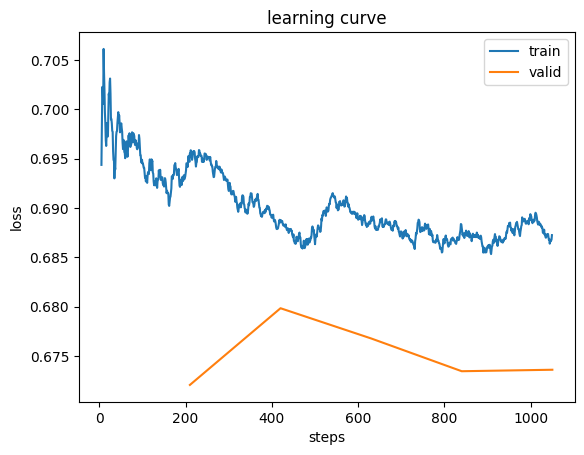

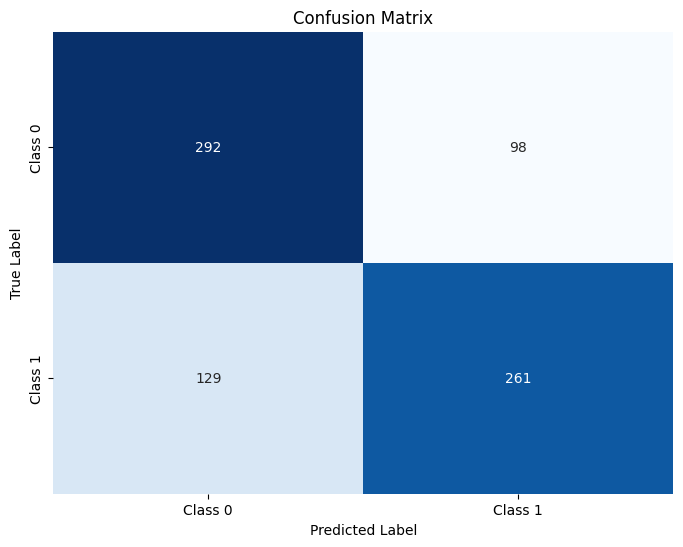

Accuracy: 0.7090
Precision: 0.7270
Recall: 0.6692
F1 Score: 0.6969
Average Precision (AP): 0.8338
Area Under ROC Curve (AUC): 0.7787


In [4]:
'''BALANCED DATA NO PCA'''

'''MY DATA'''
train_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_train.npy")
train_data = np.load(train_dir, allow_pickle=True)
# train_data = pd.DataFrame(train_data)
test_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_test.npy")
test_data = np.load(test_dir, allow_pickle=True)
# test_data = pd.DataFrame(test_data)
print(len(train_data))
print(len(test_data))
print(train_data[0])
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter

# Example dataset with windows and labels
train_windows, train_labels = create_time_windows_with_labels(train_data)
test_windows, test_labels = create_time_windows_with_labels(test_data)



import numpy as np

# Convert to numpy for easy indexing
train_windows = np.array(train_windows)
train_labels = np.array(train_labels)

# Get indices for each class
term_indices = np.where(train_labels == 0)[0]
preterm_indices = np.where(train_labels == 1)[0]

# Undersample the majority class (preterm) to match term
n_samples = min(len(term_indices), len(preterm_indices))
balanced_term_indices = np.random.choice(term_indices, n_samples, replace=False)
balanced_preterm_indices = np.random.choice(preterm_indices, n_samples, replace=False)

# Combine and shuffle
balanced_train_indices = np.concatenate([balanced_term_indices, balanced_preterm_indices])
np.random.shuffle(balanced_train_indices)

# Subset
train_windows_balanced = train_windows[balanced_train_indices]
train_labels_balanced = train_labels[balanced_train_indices]

test_windows = np.array(test_windows)
test_labels = np.array(test_labels)

term_indices = np.where(test_labels == 0)[0]
preterm_indices = np.where(test_labels == 1)[0]

n_samples = min(len(term_indices), len(preterm_indices))
balanced_term_indices = np.random.choice(term_indices, n_samples, replace=False)
balanced_preterm_indices = np.random.choice(preterm_indices, n_samples, replace=False)

balanced_test_indices = np.concatenate([balanced_term_indices, balanced_preterm_indices])
np.random.shuffle(balanced_test_indices)

test_windows_balanced = test_windows[balanced_test_indices]
test_labels_balanced = test_labels[balanced_test_indices]

train_windows = train_windows_balanced
train_labels = train_labels_balanced
test_windows = test_windows_balanced
test_labels = test_labels_balanced


# Count label distribution
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)



# Print the counts
print("Train label distribution:")
print(f"  Term (0): {train_label_counts[0]}")
print(f"  Preterm (1): {train_label_counts[1]}")

print("\nTest label distribution:")
print(f"  Term (0): {test_label_counts[0]}")
print(f"  Preterm (1): {test_label_counts[1]}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Convert to tensors
train_windows_tensor = torch.tensor(train_windows, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_windows_tensor = torch.tensor(test_windows, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

train_windows_tensor = train_windows_tensor.unsqueeze(1)  # (1071, 1, 12000)
test_windows_tensor = test_windows_tensor.unsqueeze(1)    # (899, 1, 12000)

train_labels_tensor = train_labels_tensor.long()
test_labels_tensor = test_labels_tensor.long()


print(train_labels_tensor.shape)

train_dataset = TensorDataset(train_windows_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_windows_tensor, test_labels_tensor)

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



'''CROSSENTROPY LOSS'''
from tsai.models import ResNet
from tsai.models.ResNet import ResNet
from fastai.metrics import accuracy
from fastai.data.core import DataLoaders
from fastai.learner import Learner
import torch

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wrap your DataLoaders and set device
dls = DataLoaders.from_dsets(
    train_dataset,
    test_dataset,
    bs=32,
    shuffle=True,
    num_workers=0  # avoid multiprocessing issues
)
# Define model
model = ResNet(1, 2)

# Create Learner
learn = Learner(dls, model, loss_func=torch.nn.CrossEntropyLoss(), metrics=accuracy)

# Optionally convert model to FP32 (if it was FP16 before), and ensure model is on correct device
learn.model.to(device)

learn.dls.to(device)
# Train
learn.fit_one_cycle(5, 1e-6)


learn.recorder.plot_loss()  # Plot loss curves (training and validation loss)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

# Get predictions and true labels
preds, targs = learn.get_preds(dl=learn.dls.valid)

# Convert predictions to class labels (argmax for multi-class classification)
pred_labels = preds.argmax(dim=1)

# Compute confusion matrix
cm = confusion_matrix(targs, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    roc_auc_score
)

# Convert to numpy arrays if needed
true_labels = targs.cpu().numpy()
pred_labels = pred_labels.cpu().numpy()
pred_probs = preds[:, 1].cpu().numpy()  # Probability of class 1

# Compute metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, zero_division=0)
recall = recall_score(true_labels, pred_labels, zero_division=0)
f1 = f1_score(true_labels, pred_labels, zero_division=0)
ap = average_precision_score(true_labels, pred_probs)
auc = roc_auc_score(true_labels, pred_probs)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Average Precision (AP): {ap:.4f}")
print(f"Area Under ROC Curve (AUC): {auc:.4f}")
